<a href="https://colab.research.google.com/github/beabritw/FallDetection/blob/main/DeteccaoDeQuedas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 14.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
local_path = "/content/CompleteDataSet (1).csv"

try:
    # Carrega o dataset localmente
    #data = pd.read_csv(local_path)
    data = pd.read_csv(local_path, low_memory=False)


    # Exibe as primeiras linhas para verificar o carregamento correto
    #print(data.head())
except Exception as e:
    print(f"Erro ao carregar o dataset: {e}")

In [ ]:
data.info()

In [ ]:
print("Colunas do dataset:")
print(data.columns)

In [ ]:
# Selecionar colunas relevantes
aceleracao_x_data = data['BeltAccelerometer'].values
giroscopio_x_data = data['BeltAngularVelocity'].values

In [ ]:
# Lista de colunas de aceleração e giroscópio
aceleracao_cols = [
    'AnkleAccelerometer', 'RightPocketAccelerometer', 'BeltAccelerometer',
    'NeckAccelerometer', 'WristAccelerometer'
]
giroscopio_cols = [
    'AnkleAngularVelocity', 'RightPocketAngularVelocity', 'BeltAngularVelocity',
    'NeckAngularVelocity', 'WristAngularVelocity'
]

In [ ]:
# Função para converter colunas para numérico e tratar NaNs
def process_column(data, column_name):
    # Verifica se todos os valores na coluna são numéricos
    print(data[column_name].apply(lambda x: isinstance(x, (int, float))).value_counts())

    # Converte os valores para números, substituindo strings ou valores inválidos por NaN
    data[column_name] = pd.to_numeric(data[column_name], errors='coerce')

    # Remove as linhas onde existirem NaNs (caso necessário)
    data = data.dropna(subset=[column_name])

    return data

# Processa as colunas de aceleração
for col in aceleracao_cols:
    data = process_column(data, col)

# Processa as colunas de giroscópio
for col in giroscopio_cols:
    data = process_column(data, col)

In [ ]:
# Extrai os valores da coluna após limpar os dados
aceleracao_x_data = data['BeltAccelerometer'].values
giroscopio_x_data = data['BeltAngularVelocity'].values

# Processamento para normalizar os dados para o universo fuzzy (-10 a 10)
aceleracao_x_data_normalized = np.interp(aceleracao_x_data, (aceleracao_x_data.min(), aceleracao_x_data.max()), (-10, 10))
giroscopio_x_data_normalized = np.interp(giroscopio_x_data, (giroscopio_x_data.min(), giroscopio_x_data.max()), (-10, 10))

In [ ]:
# Variáveis fuzzy de entrada
aceleracao_x_fuzzy = ctrl.Antecedent(np.arange(-10, 10, 0.1), 'aceleracao_x')
giroscopio_x_fuzzy = ctrl.Antecedent(np.arange(-10, 10, 0.1), 'giroscopio_x')

# Variável fuzzy de saída
risco_queda = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'risco_queda')


In [ ]:
# Funções de pertinência para as variáveis de entrada
aceleracao_x_fuzzy['baixa'] = fuzz.trimf(aceleracao_x_fuzzy.universe, [-10, -5, 0])
aceleracao_x_fuzzy['media'] = fuzz.trimf(aceleracao_x_fuzzy.universe, [-5, 0, 5])
aceleracao_x_fuzzy['alta'] = fuzz.trimf(aceleracao_x_fuzzy.universe, [0, 5, 10])

giroscopio_x_fuzzy['baixo'] = fuzz.trimf(giroscopio_x_fuzzy.universe, [-10, -5, 0])
giroscopio_x_fuzzy['medio'] = fuzz.trimf(giroscopio_x_fuzzy.universe, [-5, 0, 5])
giroscopio_x_fuzzy['alto'] = fuzz.trimf(giroscopio_x_fuzzy.universe, [0, 5, 10])

# Função de pertinência para a saída
risco_queda['baixo'] = fuzz.trimf(risco_queda.universe, [0.0, 0.25, 0.5])
risco_queda['medio'] = fuzz.trimf(risco_queda.universe, [0.25, 0.5, 0.75])
risco_queda['alto'] = fuzz.trimf(risco_queda.universe, [0.5, 0.75, 1.0])

In [ ]:
aceleracao_x_data.view()
giroscopio_x_data.view()

array([-1.463,  1.037,  0.366, ...,  1.28 ,  1.341,  1.646])

In [ ]:
# Definir as regras fuzzy
# Risco de Queda = Alto
regra1 = ctrl.Rule(aceleracao_x_fuzzy['alta'] & giroscopio_x_fuzzy['alto'], risco_queda['alto'])
regra2 = ctrl.Rule(aceleracao_x_fuzzy['alta'] & giroscopio_x_fuzzy['medio'], risco_queda['alto'])
regra3 = ctrl.Rule(aceleracao_x_fuzzy['media'] & giroscopio_x_fuzzy['alto'], risco_queda['alto'])

# Risco de Queda = Médio
regra4 = ctrl.Rule(aceleracao_x_fuzzy['media'] & giroscopio_x_fuzzy['medio'], risco_queda['medio'])
regra5 = ctrl.Rule(aceleracao_x_fuzzy['media'] & giroscopio_x_fuzzy['baixo'], risco_queda['medio'])
regra6 = ctrl.Rule(aceleracao_x_fuzzy['baixa'] & giroscopio_x_fuzzy['medio'], risco_queda['medio'])

# Risco de Queda = Baixo
regra7 = ctrl.Rule(aceleracao_x_fuzzy['baixa'] & giroscopio_x_fuzzy['baixo'], risco_queda['baixo'])
regra8 = ctrl.Rule(aceleracao_x_fuzzy['baixa'] & giroscopio_x_fuzzy['medio'], risco_queda['baixo'])


In [ ]:
# Sistema de controle
controle_queda = ctrl.ControlSystem([regra1, regra2, regra3, regra4, regra5, regra6, regra7, regra8])
simulacao_queda = ctrl.ControlSystemSimulation(controle_queda)

In [ ]:
# Itera sobre um subconjunto dos dados para simulação
for i in range(10):  # Executando em 10 linhas como exemplo
    try:
        # Nova instância do simulador para cada iteração
        simulacao_queda = ctrl.ControlSystemSimulation(controle_queda)

        # Entradas para a simulação
        simulacao_queda.input['aceleracao_x'] = aceleracao_x_data[i]
        simulacao_queda.input['giroscopio_x'] = giroscopio_x_data[i]

        # Executa a simulação
        simulacao_queda.compute()

        # Resultados da simulação
        resultado = simulacao_queda.output['risco_queda']
        print(f"Risco de Queda (linha {i+1}): {resultado:.2f}")
        print(f"Aceleração do Eixo X (linha {i+1}): {aceleracao_x_data[i]:.2f}")
        print(f"Giroscópio (linha {i+1}): {giroscopio_x_data[i]:.2f}")
        print("\n")

    except Exception as e:
        print(f"Erro na simulação da linha {i+1}: {e}")


Risco de Queda (linha 1): 0.51
Aceleração do Eixo X (linha 1): 0.15
Giroscópio (linha 1): -1.46


Risco de Queda (linha 2): 0.56
Aceleração do Eixo X (linha 2): 0.15
Giroscópio (linha 2): 1.04


Risco de Queda (linha 3): 0.53
Aceleração do Eixo X (linha 3): 0.18
Giroscópio (linha 3): 0.37


Risco de Queda (linha 4): 0.55
Aceleração do Eixo X (linha 4): 0.16
Giroscópio (linha 4): 0.85


Risco de Queda (linha 5): 0.61
Aceleração do Eixo X (linha 5): 0.16
Giroscópio (linha 5): 2.01


Risco de Queda (linha 6): 0.75
Aceleração do Eixo X (linha 6): 0.08
Giroscópio (linha 6): 6.34


Risco de Queda (linha 7): 0.74
Aceleração do Eixo X (linha 7): 0.06
Giroscópio (linha 7): 4.82


Risco de Queda (linha 8): 0.65
Aceleração do Eixo X (linha 8): 0.06
Giroscópio (linha 8): 3.17


Risco de Queda (linha 9): 0.59
Aceleração do Eixo X (linha 9): 0.14
Giroscópio (linha 9): 1.65


Risco de Queda (linha 10): 0.63
Aceleração do Eixo X (linha 10): 0.14
Giroscópio (linha 10): 2.74




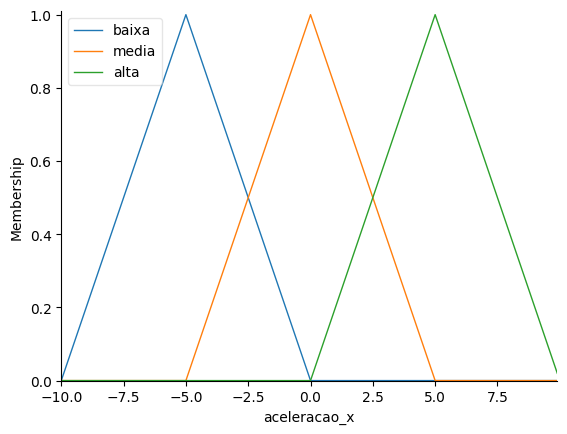

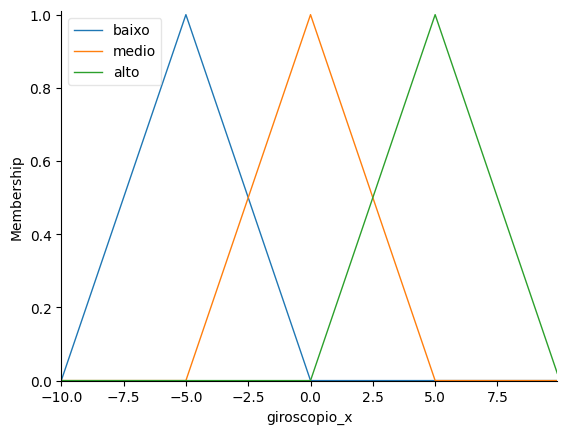

In [ ]:
# da ultima linha iterada

# Visualizar a função de pertinência de 'aceleracao_x_fuzzy'
aceleracao_x_fuzzy.view()

# Visualizar a função de pertinência de 'giroscopio_x_fuzzy'
giroscopio_x_fuzzy.view()

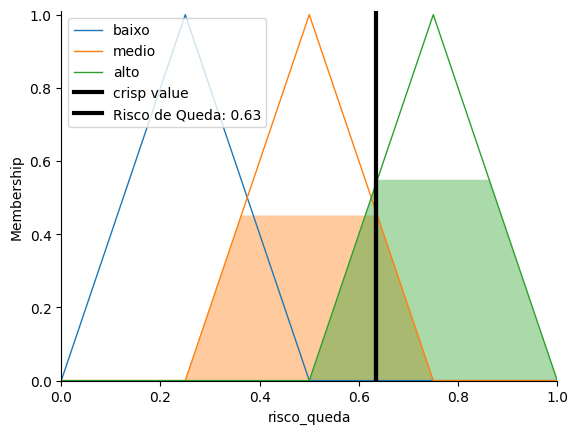

In [ ]:
# Plotando o resultado
risco_queda.view(sim=simulacao_queda)

plt.axvline(x=resultado, color='black', linewidth=3, label=f'Risco de Queda: {resultado:.2f}')

plt.legend()

plt.show()

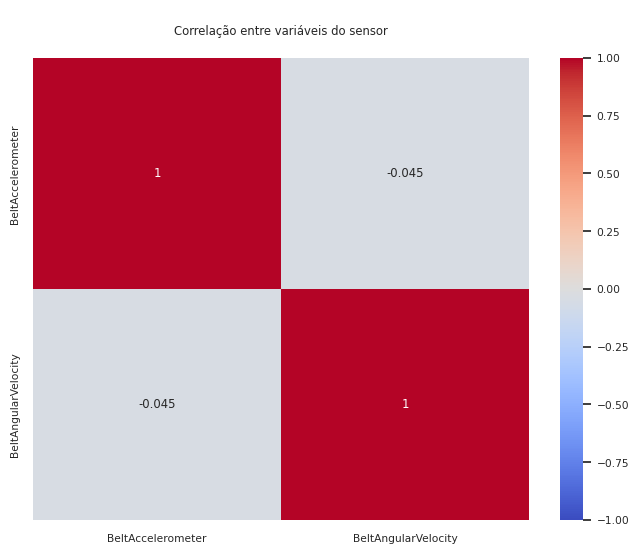

In [ ]:
# Calculando a matriz de correlação do acelerômetro do eixo X e do giroscópio utilizados
correlation_matrix = data[['BeltAccelerometer','BeltAngularVelocity']].corr()

sns.set(style='white', font_scale=0.7)  # Ajuste o valor de font_scale conforme necessário

# Plotando a matriz de correlação
plt.figure(figsize = (8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('\nCorrelação entre variáveis do sensor\n')

plt.show()


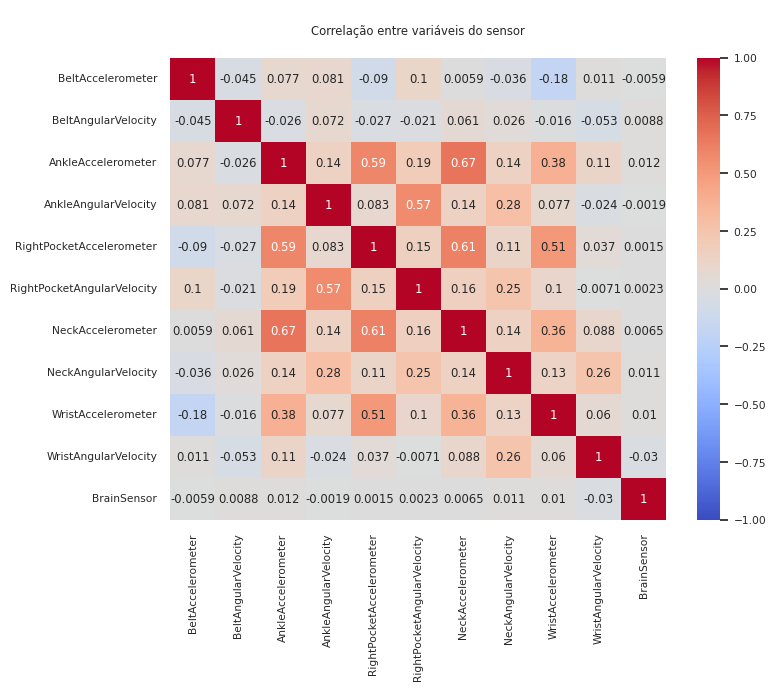

In [ ]:
# Calculando a matriz de correlação das principais colunas do Dataset
correlation_matrix = data[['BeltAccelerometer','BeltAngularVelocity', 'AnkleAccelerometer','AnkleAngularVelocity','RightPocketAccelerometer','RightPocketAngularVelocity', 'NeckAccelerometer','NeckAngularVelocity', 'WristAccelerometer','WristAngularVelocity','BrainSensor']].corr()

sns.set(style='white', font_scale=0.7)  # Ajuste o valor de font_scale conforme necessário

# Plotando a matriz de correlação
plt.figure(figsize = (8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('\nCorrelação entre variáveis do sensor\n')

plt.show()
